In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import math
import random
%matplotlib inline

In [2]:
print('OpenCv Version:',cv2.__version__)

OpenCv Version: 3.4.2


In [3]:
def display(image):
    cv2.imshow("img", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [4]:
def save(path, img):
    cv2.imwrite(path,img)

In [5]:
transA = cv2.imread("data/simA.jpg", 0)
transB = cv2.imread("data/simB.jpg", 0)
simA = cv2.imread("data/simA.jpg", 0)
simB = cv2.imread("data/simB.jpg", 0)

In [6]:
display(transB)

In [108]:
def gradients_all(img):
    ret = {}
    
    img_g = cv2.GaussianBlur(img, (5,5), sigmaX = 2)
    
    Ix = cv2.Sobel(img_g, cv2.CV_64F, 1, 0, ksize = 5) #kernel_sum = 240
    Iy = cv2.Sobel(img_g, cv2.CV_64F, 0, 1, ksize = 5)
    
    com_img = np.hstack((Ix,Iy))
#     imshow(com_img, cmap='gray');
    
    Ixx = Ix * Ix
    Ixy = Ix * Iy
    Iyy = Iy * Iy
    
    ret = {
        "img": img,
        "Ix" : Ix,
        "Iy" : Iy,
        "Ixx": Ixx,
        "Ixy": Ixy,
        "Iyy": Iyy,
          }
    
    return ret

In [8]:
ret = gradients_all(transA)
ret["Ix"]

array([[  0.,  46.,  94., ..., 262., 144.,   0.],
       [  0.,  54., 101., ..., 260., 146.,   0.],
       [  0.,  72., 117., ..., 257., 152.,   0.],
       ...,
       [  0.,  74.,  98., ...,  94.,  63.,   0.],
       [  0.,  69.,  86., ..., 138.,  89.,   0.],
       [  0.,  66.,  78., ..., 152.,  98.,   0.]])

In [9]:
def non_max_suppression(res, offset = 1):
    
    h, w = res.shape
    
    for i in range(offset, h - offset):
        for j in range(offset, w - offset):
            b = res[i - offset: i + offset + 1, j - offset: j + offset + 1]
            m = b.max()
            b[b<m] = 0
    
    return res

In [10]:
def harris_response(parameters, k = 0.05, offset = 1):
    
    img = parameters["img"]
    Ix = parameters["Ix"]
    Iy = parameters["Iy"]
    Ixx = parameters["Ixx"]
    Ixy = parameters["Ixy"]
    Iyy = parameters["Iyy"]
    
#     detA = Ixx + Iyy - 2 * Ixy
    
#     traceA = Ixx + Iyy
    
#     response = detA - k * (traceA ** 2)
    
    h,w = parameters["img"].shape
    Sxx = np.zeros((h, w)) #(h - 2 * offset,w - 2 * offset)
    Sxy = np.zeros((h, w))
    Syy = np.zeros((h, w))
    
    for i in range(offset, h - offset):
        for j in range(offset, w - offset):
            Sxx[i, j] = np.sum(Ixx[i - offset: i + offset + 1, j - offset: j + offset + 1])
            Sxy[i, j] = np.sum(Ixy[i - offset: i + offset + 1, j - offset: j + offset + 1])
            Syy[i, j] = np.sum(Iyy[i - offset: i + offset + 1, j - offset: j + offset + 1])
    
#     mat = [
#              [Sxx, Sxy]
#              [Sxy, Syy]
#           ]
    
    
    det = Sxx * Syy - Sxy ** 2
    trace = Sxx + Syy
    
    res = det - k * (trace ** 2)
    img_corners = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    corners = []
    
    #thresholding
    max_response = res.max()
    res[res < max_response * 0.01] = 0
    
    #non-max-suppression
    res = non_max_suppression(res, offset=2)
    
    
    for i in range(offset,h-offset):
        for j in range(offset,w-offset):
            if res[i, j] > 0: # response > 0 === corner
                img_corners[i, j] = [0, 255, 0]
#                 points.append([i,j])
#                 kp = cv2.KeyPoint(j,i, _size = 1, _angle=np.degrees(math.atan2(Iy[i, j+1] - Iy[i,j-1],Ix[i+1, j] - Ix[i-1,j])))
                kp = cv2.KeyPoint(j,i, _size = 2, _angle=np.degrees(math.atan(-Iy[i, j] / Ix[i, j])))
#                 kp = cv2.KeyPoint(j,i, _size = 1, _angle=np.degrees(np.arctan2(Iy[i, j],Ix[i, j]))+180)
                corners.append(kp)  
    
    #storing data
    parameters["img_corners"] = img_corners
    parameters["corners"] = corners
    parameters["response"] = res
    
    return parameters
    
    
    

In [11]:
def sift(parameters):
    
    img = parameters["img"]
    corners = parameters["corners"]
    
    #SIFT
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    parameters["keypoints"] = keypoints
    parameters["descriptors"] = descriptors
    
    img_key = cv2.drawKeypoints(parameters["img"],parameters["keypoints"],img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    display(img_key)
    
    return parameters
    
    

In [12]:
def match(p1, p2):
    
    des1 = p1["descriptors"]
    des2 = p2["descriptors"]
    
    matcher = cv2.BFMatcher()
    matches = matcher.match(des1, des2)
    
    matches = sorted(matches, key = lambda m : m.distance)
    
    return matches    

In [13]:
def compute(img):
    
    # p - parameters
    p = gradients_all(img)
    p = harris_response(p)
    p = sift(p)
    
    return p

In [14]:
parameters = harris_response(ret)

In [15]:
parameters = sift(parameters)

In [160]:
display(parameters["img_corners"])

# display(parameters["img"])

In [ ]:
# parameters["img_corners"]

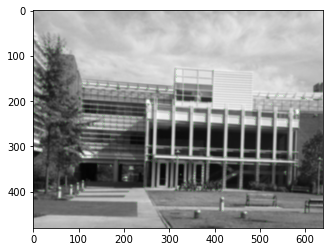

In [143]:
imshow(parameters["img_corners"]);
des_img = np.zeros((transA.shape[0],transA.shape[1],3), dtype=np.uint8)
img2 = cv2.drawKeypoints(parameters["img"],parameters["corners"], des_img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# img2 = cv2.drawKeypoints(transA,parameters["keypoints"],None,(255,0,0),10)
show(img2)

In [148]:
# sift = cv2.xfeatures2d.SIFT_create()
# kp = sift.detect(transA,None)
# img=cv2.drawKeypoints(transA,kp,transA)


In [19]:
(np.degrees(np.arctan2(parameters["Iy"],parameters["Ix"]))+180).max()

360.0

In [109]:
resA = compute(transA)
resB = compute(transB)

In [110]:
matches = match(resA, resB)

In [111]:
matches = sorted(matches, key = lambda x : x.distance)

In [112]:
img3 = cv2.drawMatches(transA, resA["keypoints"], transB, resB["keypoints"], matches[:10], outImg = transA, flags=2)
display(img3)

In [21]:
len(resB["keypoints"])

889

In [22]:
a = np.array([[]])
a[0]

array([], dtype=float64)

In [113]:
def ransac(matches,k2,k1, pick = 5, threshold = 2):
    
    ind_hits = np.array([])
    con_set  = []
    
    for i in range(pick):
        
        ind = random.choice(range(0,20))

        train_point = k1[matches[ind].trainIdx]
        query_point = k2[matches[ind].queryIdx]

        x_trans = abs(train_point.pt[0] - query_point.pt[0])
        y_trans = abs(train_point.pt[1] - query_point.pt[1])

        p = 0
        k = 0
        matched_indices = []
        
        for j in matches:
            
#             print("> looking ",x_trans,y_trans)
            p += 1
    
            train_point = k1[j.trainIdx]
            query_point = k2[j.queryIdx]
            
            x_trans_temp = abs(train_point.pt[0] - query_point.pt[0])
            y_trans_temp = abs(train_point.pt[1] - query_point.pt[1])
            
#             print("    > looking ", x_trans_temp, y_trans_temp)
            
            if x_trans_temp <= x_trans + threshold and x_trans_temp >= x_trans - threshold:
#                 print("first firewall")
                if y_trans_temp <= y_trans + threshold and y_trans_temp >= y_trans - threshold:
#                     print("second firewall", k, ind, p)
                    k += 1
                    matched_indices.append(j)
        
        print(k)
#         print(matched_indices)
            
        ind_hits = np.append(ind_hits, k)
        con_set.append(matched_indices)

    return ind_hits, con_set
            

In [114]:
kp = resA["keypoints"]

In [115]:
ind_hits, con_set = ransac(matches, resA["keypoints"], resB["keypoints"], threshold=2, pick=10)
m = ind_hits.argmax()
m

2
5
5
1
5
5
3
4
1
5


1

In [116]:
len(con_set[m])

5

In [117]:
img3 = cv2.drawMatches(transA, resA["keypoints"], transB, resB["keypoints"], con_set[m], outImg = transA, flags=2)

In [118]:
display(img3)

In [119]:
k1 = resA["keypoints"]
k2 = resB["keypoints"]
points1 = []
points2 = []
for i in range(3):
    d = con_set[m][i]
    points1.append([k2[d.trainIdx].pt[0],k2[d.trainIdx].pt[1]])
    
    points2.append([k1[d.queryIdx].pt[0],k1[d.queryIdx].pt[1]])

points1 = np.float32(points1)
points2 = np.float32(points2)

In [120]:
T = cv2.getAffineTransform(points1, points2)

In [121]:
h, w = resA["img"].shape
img = cv2.warpAffine(resB["img"], T,(w,h))

In [122]:
display(img)

In [123]:
res_new = compute(img)

In [124]:
matches_new = match(resA, res_new)

In [125]:
matches_new = sorted(matches_new, key = lambda x : x.distance)
img3 = cv2.drawMatches(transA, resA["keypoints"], img, res_new["keypoints"], matches_new[:10], outImg = transA, flags=2)
display(img3)

In [358]:
points1

array([[356.84634 , 237.71532 ],
       [110.705986, 193.5702  ],
       [347.84515 , 214.80489 ]], dtype=float32)

In [359]:
points2

array([[296.66254 , 379.27124 ],
       [110.313896, 255.22346 ],
       [289.99185 , 184.02068 ]], dtype=float32)

In [360]:
display(img)

In [377]:
l = np.copy(resA["img"])
g = np.copy(resB["img"])
for i in range(3):
    cv2.circle(g,tuple(points1[i]),1,(255,0,0))

In [378]:
display(g)

In [132]:
matches_new[5].distance

24.351591110229492